## 0. Datasets and models

### Natural images

Experiments on 40x40 Natural image patches, *with no augmentation*. Contrast of an image is defined as the standard deviation of the pixels. 

Vanilla VAE: as in the TDVAE→LinearVAE and EA-VAE arxiv paper (p.10.)

SMVAE: 1 dimension contrast variable: p(c) ~ Lognormal(0,1), while the remaining 1799 dims: p(**z**) ~ Laplace(**0, I).** Multiplication is done before the Decoder: $output=Decoder(c\cdot z)$ (multipliciation after should be the same because of the linearity)

In [11]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import make_grid

path = '../smvae_data/'

## 1. Reconstruction

In [12]:
nat_vanilla_rec = pickle.load(open(path+'LinearVAE40/notebook/LinearVAE40_reconstruction.pkl', 'rb'))
nat_smvae_rec = pickle.load(open(path+'ContrastVAE40/notebook/ContrastVAE40_reconstruction.pkl', 'rb'))

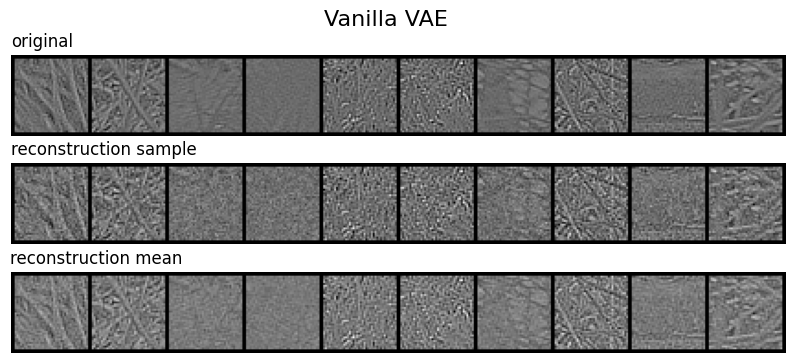

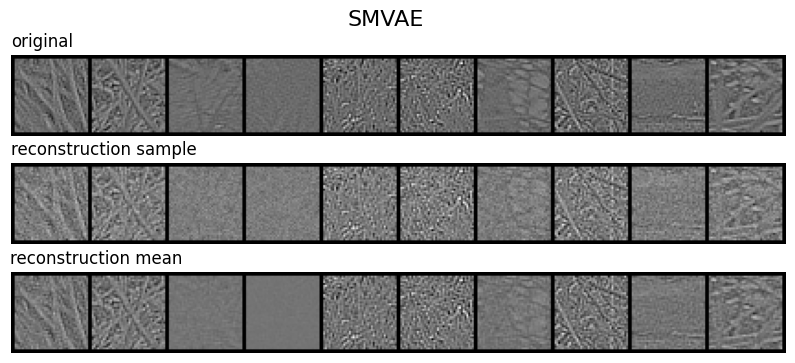

In [13]:
def compare(rec_data, n, title='Title'):
    # rec_data = (original, reconstruction_sample, reconstruction_mean)

    fig, axs = plt.subplots(3, figsize=(n,4))
    fig.suptitle(title, fontsize=16)# y=0.1)
    axs[0].set_title('original', x=0.04)#, ha='left')
    axs[1].set_title('reconstruction sample', x=0.12)
    axs[2].set_title('reconstruction mean', x=0.11)
    
    to_pil = transforms.ToPILImage()

    for i, ax in enumerate(axs):
        ax.axis('off')
        ax.imshow(to_pil(make_grid(rec_data[i][:n], nrow=n, padding=2, normalize=True)))

    plt.show()

compare(nat_vanilla_rec, 10, 'Vanilla VAE')
compare(nat_smvae_rec, 10, 'SMVAE')

In [20]:
# Gabors

nat_vanilla_receptive = pickle.load(open(path+'LinearVAE40/notebook/LinearVAE40_receptive_fields.pkl', 'rb')).reshape(-1, 1, 40, 40)
nat_vanilla_projective = pickle.load(open(path+'LinearVAE40/notebook/LinearVAE40_projective_fields.pkl', 'rb'))
nat_smvae_receptive = pickle.load(open(path+'ContrastVAE40/notebook/ContrastVAE40_receptive_fields.pkl', 'rb')).reshape(-1, 1, 40, 40)
nat_smvae_projective = pickle.load(open(path+'ContrastVAE40/notebook/ContrastVAE40_projective_fields.pkl', 'rb'))

/tmp/ipykernel_2683466/586493790.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  current_data = torch.tensor(rec_data[i]).reshape(-1, 1, 40, 40)


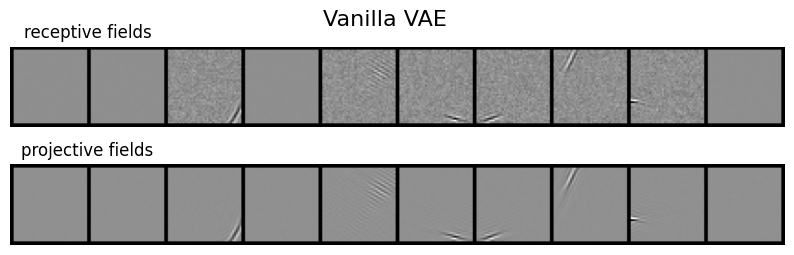

/tmp/ipykernel_2683466/586493790.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_data = torch.tensor(rec_data[i]).reshape(-1, 1, 40, 40)


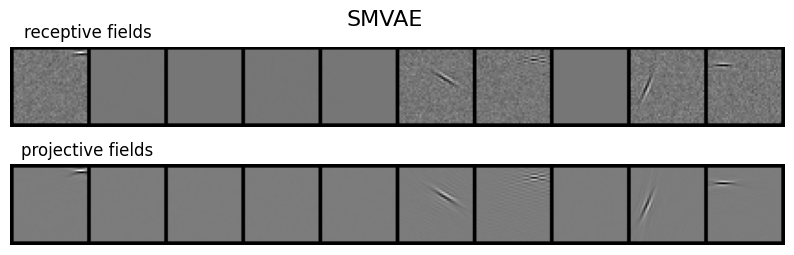

In [21]:
def plot_gabors(rec_data, n, title='Title'):
    # rec_data = (receptive_fields, projective_fields)
    fig, axs = plt.subplots(2, figsize=(n,2.8))
    fig.suptitle(title, fontsize=16)# y=0.1)
    axs[0].set_title('receptive fields', x=0.1)#, ha='left')
    axs[1].set_title('projective fields', x=0.1)
    
    to_pil = transforms.ToPILImage()

    for i, ax in enumerate(axs):
        ax.axis('off')
        current_data = torch.tensor(rec_data[i]).reshape(-1, 1, 40, 40)
        ax.imshow(to_pil(make_grid(current_data[:n], nrow=n, padding=2, normalize=True)))

    plt.show()
    
plot_gabors((nat_vanilla_receptive, nat_vanilla_projective), 10, 'Vanilla VAE')
plot_gabors((nat_smvae_receptive, nat_smvae_projective), 10, 'SMVAE')

## 2. Representation of contrast

In [14]:
nat_contrast = pickle.load(open(path+'LinearVAE40/notebook/LinearVAE40_contrast.pkl', 'rb'))
nat_vanilla_post_mean = pickle.load(open(path+'LinearVAE40/notebook/LinearVAE40_posterior_mean.pkl', 'rb'))
nat_vanilla_post_std = pickle.load(open(path+'LinearVAE40/notebook/LinearVAE40_posterior_std.pkl', 'rb'))
nat_smvae_post_mean = pickle.load(open(path+'ContrastVAE40/notebook/ContrastVAE40_posterior_mean.pkl', 'rb'))
nat_smvae_post_std = pickle.load(open(path+'ContrastVAE40/notebook/ContrastVAE40_posterior_std.pkl', 'rb'))

In [15]:
def get_correlations(contrast, latent_posterior_mean):
    latent_size = latent_posterior_mean.shape[1]
    correlations = torch.zeros(latent_size)
    for i in range(latent_size):
        current_data = torch.stack((contrast, latent_posterior_mean[:, i]))
        corr = torch.corrcoef(current_data)
        correlations[i] = corr[0, 1]
    return correlations

nat_vanilla_corr = get_correlations(nat_contrast, nat_vanilla_post_mean)
nat_smvae_corr = get_correlations(nat_contrast, nat_smvae_post_mean)

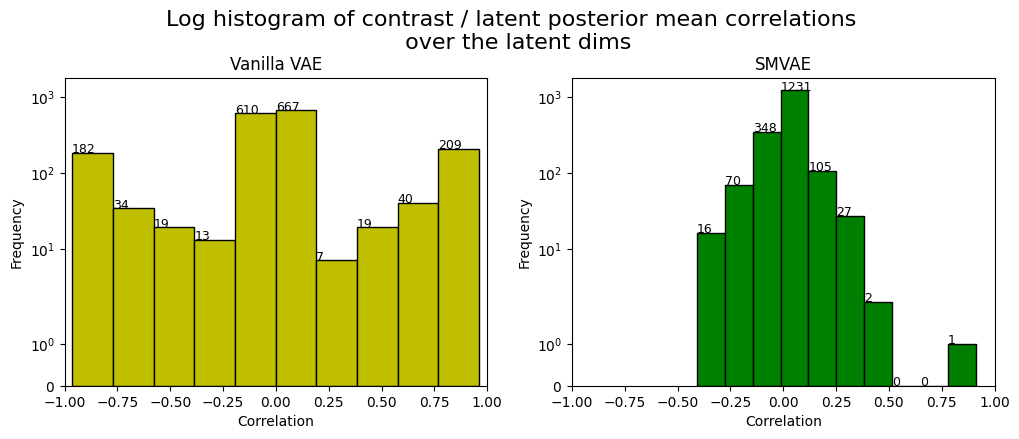

In [16]:
corr_list = [nat_vanilla_corr, nat_smvae_corr]
colors = ['y', 'g']

fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].set_title('Vanilla VAE')
axs[1].set_title('SMVAE')

for i, ax in enumerate(axs):
    n, bins, patches = ax.hist(corr_list[i], bins=10, edgecolor='black', color=colors[i])
    ax.set_xlabel('Correlation')
    ax.set_ylabel('Frequency')
    ax.set_yscale('symlog')
    ax.set_xlim(-1, 1)
    ax.set_ylim(0, 1800)
    #ax.set_xticks([i/10.0 for i in range(-10, 10, 2)])
    for count, bin in zip(n, bins):
        ax.text(bin, count, str(int(count)), fontsize=9)

plt.suptitle('Log histogram of contrast / latent posterior mean correlations \n over the latent dims', fontsize=16, y=1.05)
plt.show()

SMVAE contrast dimension's correlation:  tensor(0.9101)


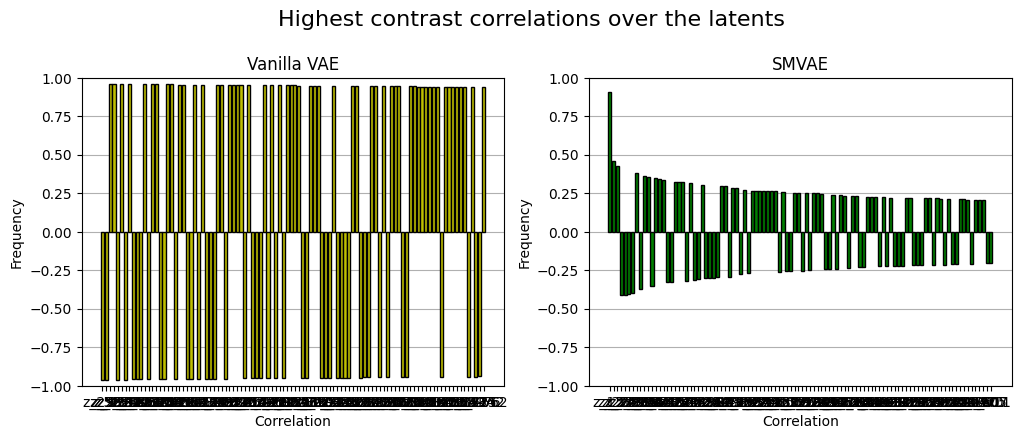

In [17]:
latent_size = nat_smvae_post_mean.shape[1] # should generalize for other models

def get_sorted(corr_data, latent_size, contrast=False):
    labels = [f'z_{i+1}' for i in range(latent_size-1)]
    labels.append('c') if contrast else labels.append(f'z_{latent_size}')
    labeled_data = [(label, corr) for label, corr in zip(labels, corr_data)]
    return sorted(labeled_data, key=lambda x: abs(x[1]), reverse=True)

sorted_corr_list = [get_sorted(nat_vanilla_corr, latent_size), get_sorted(nat_smvae_corr, latent_size, contrast=True)]
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].set_title('Vanilla VAE')
axs[1].set_title('SMVAE')
n_dims = 100
print('SMVAE contrast dimension\'s correlation: ', sorted_corr_list[1][0][1])

for i, ax in enumerate(axs):
    labels = [items[0] for items in sorted_corr_list[i]]
    values = [items[1] for items in sorted_corr_list[i]]
    ax.bar([i for i in range(n_dims)], values[:n_dims], edgecolor='black', color=colors[i], tick_label=labels[:n_dims])
    ax.set_xlabel('Correlation')
    ax.set_ylabel('Frequency')
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.set_ylim(-1, 1)

plt.suptitle(f'Highest contrast correlations over the latents', fontsize=16, y=1.05)
plt.show()

**Posterior mean & variance**

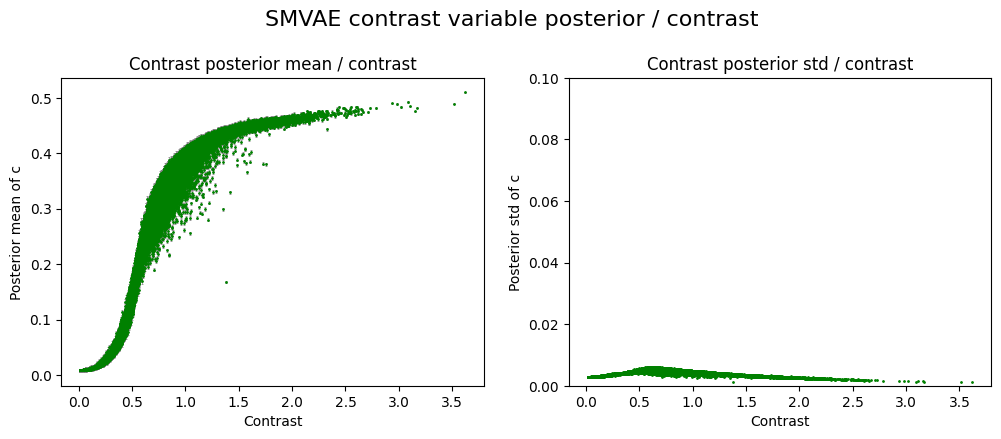

In [18]:
nat_c_post_mean = nat_smvae_post_mean[:, -1]
nat_c_post_std = nat_smvae_post_std[:, -1]

def plot_contrasts(contrast, post_mean, post_std, colors=['y', 'g']):
    fig, axs = plt.subplots(1, 2, figsize=(12,4))

    axs[0].scatter(contrast, post_mean, s=1, c=colors[1])
    axs[0].set_xlabel('Contrast')
    axs[0].set_ylabel('Posterior mean of c')
    axs[0].set_title('Contrast posterior mean / contrast')
    axs[0].errorbar(contrast, post_mean, yerr=post_std, c='grey', fmt='none', capsize=1, elinewidth=0.5, capthick=0.5, zorder=0)
    #bottom, top = axs[0].get_ylim()  # return the current ylim
    #axs[0].set_ylim(bottom, top)   # set the ylim to bottom, top

    axs[1].scatter(contrast, post_std, s=1, c=colors[1])
    axs[1].set_xlabel('Contrast')
    axs[1].set_ylabel('Posterior std of c')
    axs[1].set_title('Contrast posterior std / contrast')
    axs[1].set_ylim(0, 0.1)

    plt.suptitle('SMVAE contrast variable posterior / contrast', fontsize=16, y=1.05)
    plt.show()

plot_contrasts(nat_contrast, nat_c_post_mean, nat_c_post_std)

In [22]:
from hvae_backbone.analysis import feri_score

threshold = 1e4

vanilla_score = np.array(feri_score(np.array(nat_vanilla_projective)))
vanilla_active = np.where(vanilla_score > threshold, 0, 1)

smvae_score = np.array(feri_score(np.array(nat_smvae_projective)))
smvae_active = np.where(smvae_score > threshold, 0, 1)

In [23]:
def get_posterior_activations(contrasts, where_active, post_std):
    len_data = contrasts.shape[0]
    #active_means = torch.zeros(len_data)
    active_stds_mean = torch.zeros(len_data)
    active_stds_std = torch.zeros(len_data)
    #passive_means = torch.zeros(len_data)
    passive_stds_mean = torch.zeros(len_data)
    passive_stds_std = torch.zeros(len_data)

    for i in range(len_data): 
        #active_means[i] = torch.mean(post_mean[i, where_active==1])
        active_stds_mean[i] = torch.mean(post_std[i, where_active==1])
        active_stds_std[i] = torch.std(post_std[i, where_active==1])
        #passive_means[i] = torch.mean(post_mean[i, where_active==0])
        passive_stds_mean[i] = torch.mean(post_std[i, where_active==0])
        passive_stds_std[i] = torch.std(post_std[i, where_active==0])

    return active_stds_mean, active_stds_std, passive_stds_mean, passive_stds_std

vanilla_active_stds_mean, vanilla_active_stds_std, vanilla_passive_stds_mean, vanilla_passive_stds_std = get_posterior_activations(nat_contrast, vanilla_active, nat_vanilla_post_std)
smvae_active_stds_mean, smvae_active_stds_std, smvae_passive_stds_mean, smvae_passive_stds_std = get_posterior_activations(nat_contrast, smvae_active, nat_smvae_post_std)


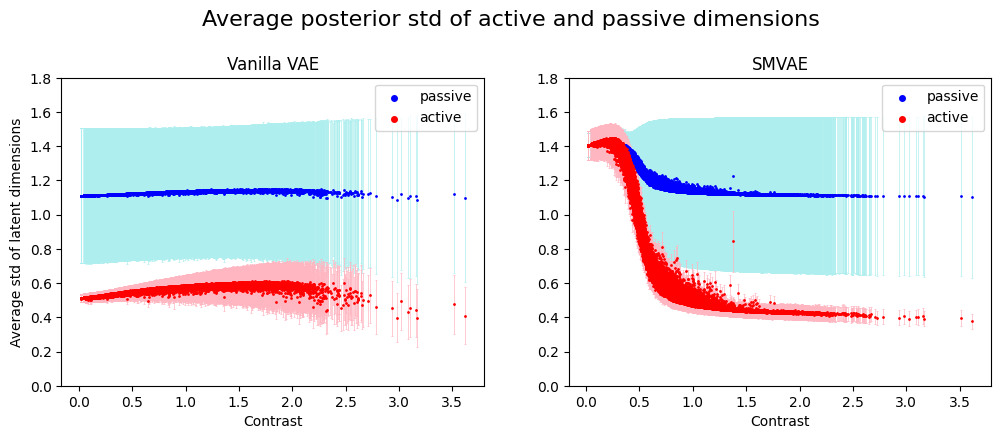

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].scatter(nat_contrast, vanilla_passive_stds_mean, s=1, c='b')
axs[0].errorbar(nat_contrast, vanilla_passive_stds_mean, yerr=vanilla_passive_stds_std, c='paleturquoise', fmt='none', capsize=1, elinewidth=0.5, capthick=0.5, zorder=0)
axs[0].scatter(nat_contrast, vanilla_active_stds_mean, s=1, c='r')
axs[0].errorbar(nat_contrast, vanilla_active_stds_mean, yerr=vanilla_active_stds_std, c='lightpink', fmt='none', capsize=1, elinewidth=0.5, capthick=0.5, zorder=0)
axs[0].set_xlabel('Contrast')
axs[0].set_ylabel('Average std of latent dimensions')
axs[0].set_title('Vanilla VAE')
axs[0].set_ylim(0, 1.8)
axs[0].legend(['passive', 'active'], loc='upper right', markerscale=4)

axs[1].scatter(nat_contrast, smvae_passive_stds_mean, s=1, c='b')
axs[1].errorbar(nat_contrast, smvae_passive_stds_mean, yerr=smvae_passive_stds_std, c='paleturquoise', fmt='none', capsize=1, elinewidth=0.5, capthick=0.5, zorder=0)
axs[1].scatter(nat_contrast, smvae_active_stds_mean, s=1, c='r')
axs[1].errorbar(nat_contrast, smvae_active_stds_mean, yerr=smvae_active_stds_std, c='lightpink', fmt='none', capsize=1, elinewidth=0.5, capthick=0.5, zorder=0)
axs[1].set_xlabel('Contrast')
axs[1].set_title('SMVAE')
axs[1].set_ylim(0, 1.8)
axs[1].legend(['passive', 'active'], loc='upper right', markerscale=4)

plt.suptitle(f'Average posterior std of active and passive dimensions', fontsize=16, y=1.05)
plt.show()